In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# 1. Implementing structured-light triangulation

## 1.1 Video processing

In [4]:
def save_frames(video_path, output_dir, save_rate):
    """
    Save frames from the video at a specific rate.

    :param video_path: Path to the video file.
    :param output_dir: Directory where the frames will be saved.
    :param save_rate: Rate at which frames are saved (e.g., 1 frame per second).
    """
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Get the frame rate of the video
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Calculate the interval at which frames should be saved
    frame_interval = int(fps / save_rate)

    frame_count = 0
    saved_frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Save the frame if it matches the interval
        if frame_count % frame_interval == 0:
            cv2.imwrite(os.path.join(output_dir, f"frame_{saved_frame_count}.png"), frame)
            saved_frame_count += 1

        frame_count += 1

    cap.release()
    print(f"Frames saved: {saved_frame_count}")

# # Usage
# video_file_path = './data/my/calib.mov'  # Replace with your .mov file path
# output_directory = './data/my/calib_all_frm'   # Replace with your desired output directory
# frame_save_rate = 10  # Save 1 frame per second, adjust as needed

# save_frames(video_file_path, output_directory, frame_save_rate)


In [7]:
# Usage
video_file_path = './data/my/jar.mov'  # Replace with your .mov file path
output_directory = './data/my/jar'   # Replace with your desired output directory
frame_save_rate = 10  # Save 1 frame per second, adjust as needed

save_frames(video_file_path, output_directory, frame_save_rate)

Frames saved: 197


### Per-frame shadow edge estimation, Per-pixel shadow time estimation

In [142]:
import re

def sort_key(filename):
    # Use regular expression to find the number in the filename
    match = re.search(r'frame_(\d+).png', filename)
    # If the pattern is found, return the number as an integer
    if match:
        return int(match.group(1))
    # If no number is found, return a default value
    return 0

# Define the path to the directory containing the images
img_path = './data/my/jar'

# List all files in the directory
files_list = os.listdir(img_path)

files_list = [f for f in files_list if f.endswith('.png')]

# Sort the files using the custom sort function
files_list.sort(key=sort_key)

# Initialize an empty list to store the images
img_list = []

# Iterate over the sorted and filtered list of image files
for file_name in files_list:
    # Construct the full path to the image file
    full_path = os.path.join(img_path, file_name)

    # Read the image from the file
    img = cv2.imread(full_path)
    # Convert the image to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img[:, 400:1550]
    
    #apply bilateral filter
    img = cv2.bilateralFilter(img, 5, 10, 10)
    # plt.imshow(img, cmap='gray')

    # Append the processed image to the list
    img_list.append(img)

# Convert the list of images to a NumPy array for further processing
img_list = np.array(img_list)

# Load and convert the first image in the list for visualization
image_color = cv2.imread(os.path.join(img_path, files_list[0]))
image_color = cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB)
image_color = image_color[:, 400:1550] 


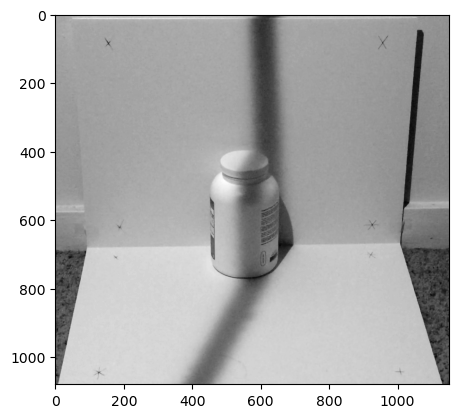

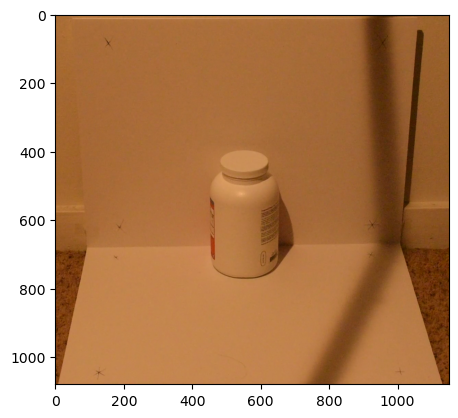

In [143]:
plt.imshow(img_list[30], cmap='gray')
plt.show()
plt.imshow(image_color)

In [115]:
def per_frame_shadow_edge_estimation(I, offset_row, offset_col):
    """
    Estimates the shadow edge per frame.

    :param I: Input image sequence.
    :param offset_row: Row offset for point calculation.
    :param offset_col: Column offset for point calculation.
    :return: Line parameters and array of points for each frame.
    """
    I_max = np.max(I, 0)
    I_min = np.min(I, 0)
    I_shadow = (I_max + I_min) / 2
    diff_image = np.zeros(I.shape)

    # Calculating the difference between each frame and the shadow
    for t in range(I.shape[0]):
        diff_image[t] = I[t] - I_shadow

    line_params = np.zeros((3, I.shape[0]))
    pts_arr = []

    # Estimating the shadow edge for each frame
    for t in range(diff_image.shape[0]):
        pts = []
        for i in range(diff_image.shape[1]):
            cur_pt = []
            cur_neg_count = 0
            for j in range(diff_image.shape[2] - 1):
                if diff_image[t][i][j] < 0:
                    cur_neg_count += 1
                else:
                    cur_neg_count = 0

                if diff_image[t][i][j + 1] >= 0 and diff_image[t][i][j] < 0 and cur_neg_count >= 10:
                    cur_pt = [i + offset_row, j + offset_col, 1]

            if cur_pt:
                pts.append(cur_pt)

        if not pts:
            break

        pts = np.array(pts)
        _, _, vh = np.linalg.svd(pts)
        line_params[:, t] = vh[:, -1]
        pts_arr.append(pts)

    pts_arr = np.array(pts_arr)
    return line_params, pts_arr


def per_pixel_shadow_time_estimate(I):
    """
    Estimates the time each pixel spends in the shadow.

    :param I: Input image sequence.
    :return: Shadow time and shadow time plot arrays.
    """
    I_max = np.max(I, 0)
    I_min = np.min(I, 0)
    I_shadow = (I_max + I_min) / 2
    diff_image = np.zeros(I.shape)
    shadow_time = np.zeros(I_shadow.shape)
    shadow_time_plot = np.zeros(I_shadow.shape)

    # Calculating the shadow time for each pixel
    for t in range(I.shape[0]):
        diff_image[t] = I[t] - I_shadow

    bucket_size = diff_image.shape[0] / 32

    for i in range(diff_image.shape[1]):
        for j in range(diff_image.shape[2]):
            diff = -np.inf
            for t in range(diff_image.shape[0] - 1):
                if diff_image[t + 1][i][j] - diff_image[t][i][j] > diff:
                    shadow_time[i][j] = t
                    shadow_time_plot[i][j] = t // bucket_size
                    diff = diff_image[t + 1][i][j] - diff_image[t][i][j]

    # Masking low contrast areas
    shadow_time[I_max - I_min < 35] = 0
    shadow_time_plot[I_max - I_min < 35] = 0

    return shadow_time, shadow_time_plot

# Define bounds for horizontal and vertical planes
hor_start_row, hor_end_row = 780, 1080
hor_start_col, hor_end_col = 0, 900
hor_start_frame, hor_end_frame = 47, 166

ver_start_row, ver_end_row = 0, 400
ver_start_col, ver_end_col = 0, 1000
ver_start_frame, ver_end_frame = 47, 166

# Extract horizontal and vertical segments from the image list
I_horizontal = img_list[:,
                        hor_start_row:hor_end_row,
                        hor_start_col:hor_end_col]

I_vertical = img_list[:,
                      ver_start_row:ver_end_row,
                      ver_start_col:ver_end_col]

# Estimate line parameters and points for horizontal and vertical segments
line_params_horizontal, pts_hor = per_frame_shadow_edge_estimation(I_horizontal / 255, hor_start_row, hor_start_col)
line_params_vertical, pts_ver = per_frame_shadow_edge_estimation(I_vertical / 255, ver_start_row, ver_start_col)

# Adjust vertical points
# pts_ver = pts_ver[:-1]

# Estimate shadow time for the entire image sequence
shadow_time, shadow_time_plot = per_pixel_shadow_time_estimate(img_list)

/var/folders/sx/x97pflv53g7fw_fwz8qq6xzh0000gn/T/ipykernel_5093/454547252.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pts_arr = np.array(pts_arr)


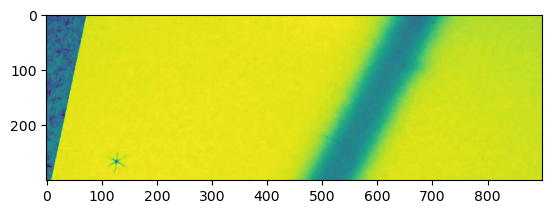

In [116]:
plt.imshow(I_horizontal[19, :, :])

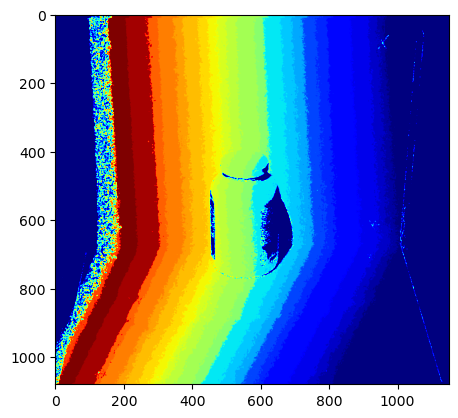

In [119]:
# %matplotlib notebook
# %matplotlib ipympl
%matplotlib inline
# %matplotlib ipympl

plt.imshow(shadow_time_plot, cmap='jet')
plt.show()


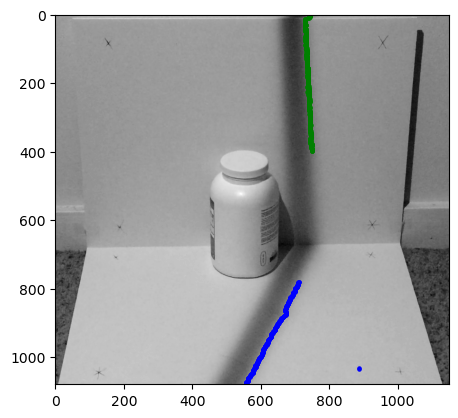

In [172]:
%matplotlib inline

num_frame = 20
plt.figure()
plt.imshow(img_list[num_frame], cmap='gray')
plt.scatter(pts_hor[num_frame][:,1],pts_hor[num_frame][:,0], c='b', s = 5)
plt.scatter(pts_ver[num_frame][:,1],pts_ver[num_frame][:,0], c='g', s = 5)

## 1.2 Intrinsic and extrinsic calibration

In [126]:
from src.cp_hw6 import pixel2ray
# load intrinsic and extrinsic parameters
intrinsic = np.load('data/my/calib/intrinsic_calib.npz')
extrinsic = np.load('data/my/jar/extrinsic_calib.npz')
# extrinsics = np.load('data/frog/extrinsic_calib_ref.npz')
R_h,t_h = extrinsic['rmat_h'], extrinsic['tvec_h']
R_v,t_v = extrinsic['rmat_v'], extrinsic['tvec_v']
K = intrinsic['mtx']
distortion = intrinsic['dist']

In [127]:
print('Intrinsic parameters:\n', K)
print('Rotation matrix of h plane\n', R_h, '\nTranslation matrix of h plane\n', t_h)
print('Rotation matrix of v plane\n', R_v, '\nTranslation matrix of v plane\n', t_v)

Intrinsic parameters:
 [[3.23403571e+03 0.00000000e+00 9.44488290e+02]
 [0.00000000e+00 3.27209775e+03 4.15862782e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Rotation matrix of h plane
 [[ 9.99576611e-01 -2.66218043e-02  1.17421630e-02]
 [-3.19151662e-04 -4.13568459e-01 -9.10472969e-01]
 [ 2.90946215e-02  9.10083738e-01 -4.13401855e-01]] 
Translation matrix of h plane
 [[-212.2233702 ]
 [ 319.23083096]
 [1630.21697049]]
Rotation matrix of v plane
 [[ 0.99997256 -0.00305111  0.00675029]
 [-0.00591892 -0.87702895  0.48040107]
 [ 0.00445444 -0.48042784 -0.87702295]] 
Translation matrix of v plane
 [[-217.59967013]
 [ 125.69763915]
 [1988.85337707]]


In [128]:
def compute_3D_coordi_plane(line_pt_plane, r_plane, plane_pt, plane_normal):
    """
    Computes the 3D coordinates where a ray intersects a plane.

    :param line_pt_plane: A point on the line in plane coordinates.
    :param r_plane: The direction vector of the ray in plane coordinates.
    :param plane_pt: A point on the plane in plane coordinates.
    :param plane_normal: The normal vector of the plane.
    :return: The 3D coordinates of the intersection, or None if there is no intersection.
    """
    ndotr = np.dot(r_plane, plane_normal)
    if ndotr == 0:
        return None  # Ray and plane are parallel, so no intersection (this won't happen in our case)
    
    w = line_pt_plane - plane_pt
    si = -np.dot(w, plane_normal) / ndotr
    Psi = w + si * r_plane + plane_pt
    
    return Psi

def compute_3D_coordi_camera(p1, p2, R, t):
    """
    Computes the 3D coordinates of points in camera space given their 2D projections.

    :param p1: The 2D coordinates of the first point.
    :param p2: The 2D coordinates of the second point.
    :param R: The rotation matrix of the camera.
    :param t: The translation vector of the camera.
    :return: The 3D coordinates of the points in camera space.
    """
    p = np.array([p1, p2]).astype('float64')
    r = pixel2ray(p, K, distortion)  # Convert pixels to 3D rays in camera coordinates
    r = r.squeeze().T  # Reshaping to 3 * N

    r_plane = R.T @ r  # Transforming the 3D rays to plane coordinates

    # Compute a point on the ray line in plane coordinates
    line_pt = np.array([0, 0, 0]).reshape((3, 1))
    line_pt_plane = R.T @ (line_pt - t)  # Transforming to plane coordinates
    line_pt_plane = line_pt_plane.squeeze()

    # Define a point on the plane and the plane's normal in plane coordinates
    plane_pt = np.array([0, 0, 0]).reshape((3))
    plane_normal = np.array([0, 0, 1]).reshape((3))  # Normal of the plane

    # Compute the 3D coordinates of the points in the plane coordinates
    P1_plane = compute_3D_coordi_plane(line_pt_plane, r_plane[:, 0], plane_pt, plane_normal)
    P2_plane = compute_3D_coordi_plane(line_pt_plane, r_plane[:, 1], plane_pt, plane_normal)

    P1_plane = P1_plane.reshape((3, 1))
    P2_plane = P2_plane.reshape((3, 1))

    # Transform the points back to camera coordinates
    P1_cam = R @ P1_plane + t
    P2_cam = R @ P2_plane + t
    
    return P1_cam, P2_cam


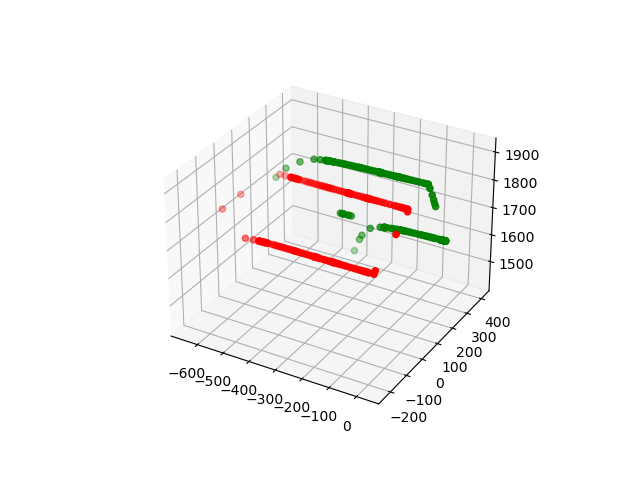

In [173]:
# collecting 3D points (Calibrating shadow lines)

P1_array, P2_array = [], []

for t in range(pts_hor.shape[0]):
    # print(t)
    p1 = pts_hor[t][1][:-1][::-1] # flipping x and y
    p2 = pts_hor[t][-1][:-1][::-1]
    P1, P2 = compute_3D_coordi_camera(p1, p2, R_h, t_h)
    P1_array.append(P1)
    P2_array.append(P2)

P1_array = np.array(P1_array).squeeze()
P2_array = np.array(P2_array).squeeze()


P3_array, P4_array = [], []

for t in range(pts_ver.shape[0]) :
    # p3 = pts_ver[t][70][:-1][::-1]
    p3 = pts_ver[t][10][:-1][::-1]
    p4 = pts_ver[t][-10][:-1][::-1]
    P3, P4 = compute_3D_coordi_camera(p3, p4, R_v, t_v)
    P3_array.append(P3)
    P4_array.append(P4)

P3_array = np.array(P3_array).squeeze()
P4_array = np.array(P4_array).squeeze()

%matplotlib ipympl
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(P1_array[:,0],P1_array[:,1],P1_array[:,2], c='g', label='P1')
ax.scatter(P2_array[:,0],P2_array[:,1],P2_array[:,2], c='g', label='P2')
ax.scatter(P3_array[:,0],P3_array[:,1],P3_array[:,2], c='r', label='P3')
ax.scatter(P4_array[:,0],P4_array[:,1],P4_array[:,2], c='r', label='P4')

In [131]:
def estimate_shadow_plane(P1, P2, P3, P4):
    """
    Estimates the normal of the shadow plane given four points in 3D space.

    :param P1, P2, P3, P4: Four 3D points defining the shadow plane.
    :return: A point on the plane and the normalized normal vector of the plane.
    """
    # Compute the normal vector of the plane using the cross product
    n = np.cross((P2 - P1), (P4 - P3))
    # Normalize the normal vector
    n_norm = n / np.linalg.norm(n)
    
    return P1, n_norm

def compute_3D_coordi_shadow_plane(p, S):
    """
    Computes the 3D coordinates of a point in the shadow plane, given its 2D image coordinates.

    :param p: The 2D image coordinates of the point.
    :param S: A dictionary containing 'P1' (a point on the shadow plane) and 'n_norm' (the normal of the shadow plane).
    :return: The 3D coordinates of the point in the shadow plane.
    """
    # Prepare the 2D point for ray computation
    p = np.array([p, p]).astype('float64')
    # Convert the 2D point to a 3D ray in camera coordinates
    r = pixel2ray(p, K, distortion)
    r = r.squeeze().T  # Reshape to get 3 * N

    # Define a point on the ray line in camera coordinates
    line_pt = np.array([0, 0, 0])
    
    # Extract the plane normal and a point on the plane from the shadow plane data
    plane_normal = S['n_norm']
    plane_point = S['P1']

    # Compute the 3D coordinates where the ray intersects the shadow plane
    P = compute_3D_coordi_plane(line_pt, r[:, 0], plane_point, plane_normal)
    
    return P

# Calibrating Shadow planes
n_array = []
S_array = []
for t in range(len(P1_array)) : 
    _, n_norm = estimate_shadow_plane(P1_array[t],P2_array[t],P3_array[t],P4_array[t])
    n_array.append(n_norm)
    S_array.append({'P1' : P1_array[t], 'n_norm' : n_norm})
n_array = np.array(n_array)

## 1.3 Reconstruction (25 points)

In [169]:
# Define the bounds of the rectangle for reconstruction
rectangle_bounds_col = [300, 650]  # Bounds for columns
rectangle_bounds_row = [400, 770]  # Bounds for rows

# Initialize arrays to store 3D points and their corresponding colors
P_array = []
p_color_array = []

# Iterate over the rows and columns within the defined rectangle bounds
for row in range(rectangle_bounds_row[0], rectangle_bounds_row[1], 4):
    for col in range(rectangle_bounds_col[0], rectangle_bounds_col[1], 4):
        
        # Get the shadow time for the current pixel
        st = shadow_time[row, col]
        # Adjust the shadow time offset
        st_offset_adjusted = int(st - ver_start_frame)
        st_offset_adjusted = max(0, min(st_offset_adjusted, 80))

        # Get the shadow plane parameters at the adjusted shadow time
        S = S_array[st_offset_adjusted]

        # Compute the 3D coordinates of the point in the shadow plane
        p = np.array([col, row])
        P = compute_3D_coordi_shadow_plane(p, S)
        P_array.append(P)
        
        # Append the color of the point
        p_color_array.append(image_color[row, col])
        
# Convert the lists to numpy arrays for further processing
P_array = np.array(P_array)
p_color_array = np.array(p_color_array)

# Filtering points based on magnitude

thresh_dist = 1800
thresh_z = 1400

# Filter out points for just the frog (based on a distance threshold)
P_array_filtered = P_array[np.linalg.norm(P_array, axis=1) < thresh_dist]
p_color_array_filtered = p_color_array[np.linalg.norm(P_array, axis=1) < thresh_dist]

# # Further filtering for frog with background based on the Z-coordinate
# P_array_filtered = P_array_filtered[P_array_filtered[:, 2] < 2500]
# p_color_array_filtered = p_color_array_filtered[P_array_filtered[:, 2] < 2500]

# Additional filtering based on the Z-coordinate
# p_color_array_filtered = p_color_array_filtered[P_array_filtered[:, 2] > 1700]
p_color_array_filtered = p_color_array_filtered[P_array_filtered[:, 2] > thresh_z]
P_array_filtered = P_array_filtered[P_array_filtered[:, 2] > thresh_z]


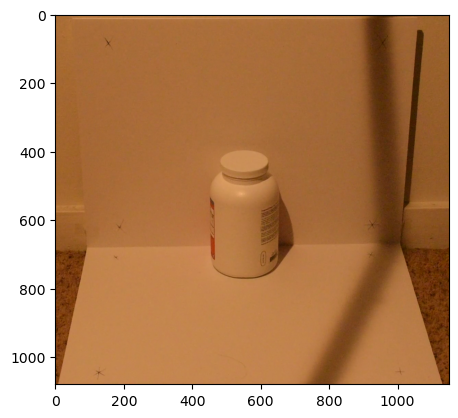

In [170]:
%matplotlib inline

plt.imshow(image_color)

Text(0.5, 0, 'Z')

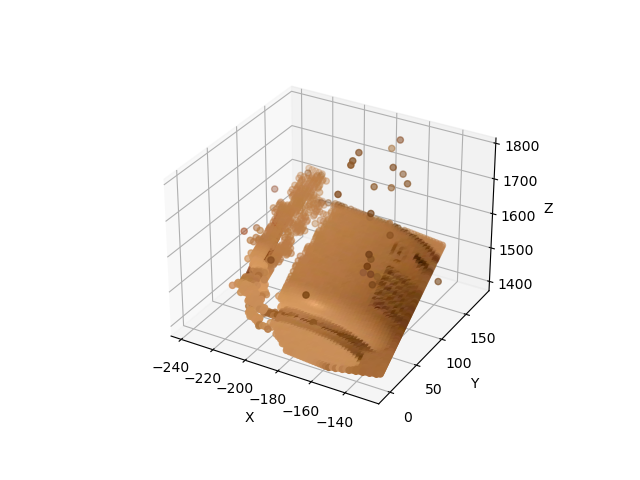

In [174]:
# %matplotlib notebook
%matplotlib ipympl

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(P_array_filtered[:,0],P_array_filtered[:,1],P_array_filtered[:,2],c=p_color_array_filtered/255)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')